## Pricing Plain-Vanilla Options on US Large-Cap Blue-Chip Stocks  
**Author:** Faye Panagiotou ([faye.panagiotou@hec.edu](mailto:faye.panagiotou@hec.edu))  
**Degree:** MSc International Finance, HEC Paris  

💼 Objective:
Quantiative analysis of option prices under different market dynamics, as would be monitored on an S&T (Sales & Trading) desk.

🛠 Models Implemented:

1. **Black-Scholes Model (1973)** - Constant volatility model; the foundational closed-form model for European options.
2. **Heston Model (1993)** - Stochastic volatility model allowing volatility to evolve randomly over time.
3. **Bates Model (1996)** - Extension of Heston with jumps in the underlying asset price.

📊 Methodology:

1. Downloaded historical data for 6 US large-cap blue-chip stocks from Investing.com using `investpy`.
2. Simulated Monte Carlo price paths under each model.
3. Priced 6M maturity, 105% strike European call options.
4. Performed scenario analysis for spot shocks of ±5%, ±10%, and ±20%.

🎯 Outputs:

- **Change in Option Price** (PnL-style) relative to baseline (0% shock).

📌 This project demonstrates applied quantitative finance skills in derivatives pricing, stochastic modeling and risk scenario analysis - all critical in trading, structuring, and risk management.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import investpy
import scipy.stats as st

sns.set_theme(style='whitegrid')
plt.rcParams['font.family'] = 'serif'


## 1. Data Download

In [12]:
def get_stocks_data(tickers, country, from_date, to_date):
    data_dict = {}
    for ticker in tickers:
        search_result = investpy.search_quotes(
            text=ticker,
            products=['stocks'],
            countries=[country],
            n_results=1
        )
        df = search_result.retrieve_historical_data(from_date=from_date, to_date=to_date)
        data_dict[ticker] = df['Close']
    return pd.DataFrame(data_dict)

stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA']
stocks_df = get_stocks_data(stocks, 'united states', '01/01/2024', '01/01/2025')
stocks_df.tail()

,AAPL,MSFT,GOOGL,AMZN,META,NVDA
Date,,,,,,
2024-12-24,258.20,439.33,196.11,229.05,607.75,140.22
2024-12-26,259.02,438.11,195.60,227.05,603.35,139.93
2024-12-27,255.59,430.53,192.76,223.75,599.81,137.01
2024-12-30,252.20,424.83,191.24,221.30,591.24,137.49
2024-12-31,250.42,421.50,189.30,219.39,585.51,134.29


## 2. Model Definitions

In [9]:
# Black-Scholes Model
def simulate_bs(S0, mu, sigma, T, N, M):
    dt = T / N
    W = np.random.normal(0, np.sqrt(dt), (M, N))
    W = np.cumsum(W, axis=1)
    time = np.linspace(0, T, N)
    S = S0 * np.exp((mu - 0.5 * sigma**2) * time + sigma * W)
    return S

# Heston Model
def simulate_heston(S0, v0, r, kappa, theta, sigma_v, rho, T, N, M):
    dt = T / N
    S = np.zeros((M, N))
    v = np.zeros((M, N))
    S[:, 0] = S0
    v[:, 0] = v0
    for t in range(1, N):
        z1 = np.random.normal(size=M)
        z2 = rho * z1 + np.sqrt(1 - rho**2) * np.random.normal(size=M)
        v[:, t] = np.maximum(v[:, t-1] + kappa*(theta - v[:, t-1])*dt +
                             sigma_v*np.sqrt(v[:, t-1]*dt)*z2, 0)
        S[:, t] = S[:, t-1] * np.exp((r - 0.5*v[:, t-1])*dt +
                                     np.sqrt(v[:, t-1]*dt)*z1)
    return S, v

# Bates Model
def simulate_bates(S0, v0, r, kappa, theta, sigma_v, rho,
                   lam, mu_j, sigma_j, T, N, M):
    dt = T / N
    S = np.zeros((M, N))
    v = np.zeros((M, N))
    S[:, 0] = S0
    v[:, 0] = v0
    for t in range(1, N):
        z1 = np.random.normal(size=M)
        z2 = rho * z1 + np.sqrt(1 - rho**2) * np.random.normal(size=M)
        dN = np.random.poisson(lam * dt, M)
        J = np.random.normal(mu_j, sigma_j, M) * dN
        v[:, t] = np.maximum(v[:, t-1] + kappa*(theta - v[:, t-1])*dt +
                             sigma_v*np.sqrt(v[:, t-1]*dt)*z2, 0)
        S[:, t] = S[:, t-1] * np.exp((r - 0.5*v[:, t-1])*dt +
                                     np.sqrt(v[:, t-1]*dt)*z1 + J)
    return S, v

## 3. Descriptive Plot - Historical Prices

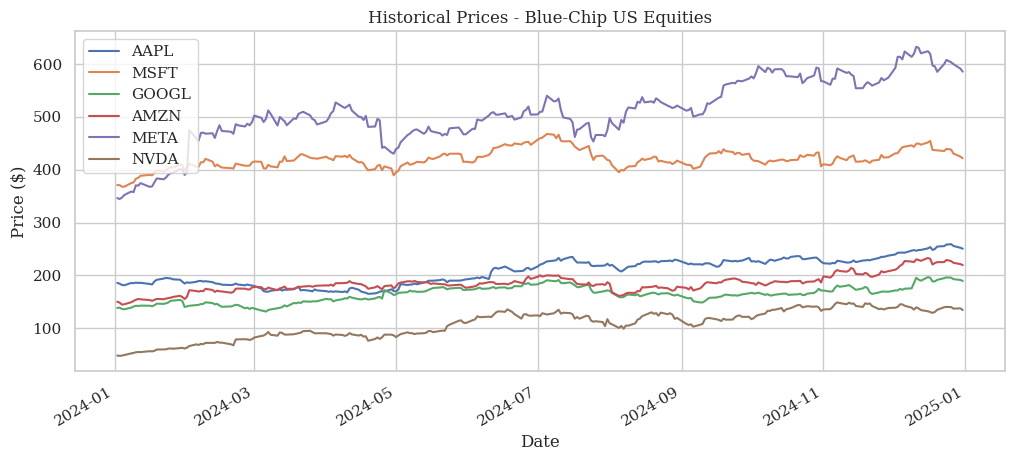

In [10]:
plt.figure(figsize=(12, 5))
stocks_df.plot(ax=plt.gca())
plt.title('Historical Prices - Blue-Chip US Equities')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.legend()
plt.show()

## 4. Scenario Analysis - PnL Change

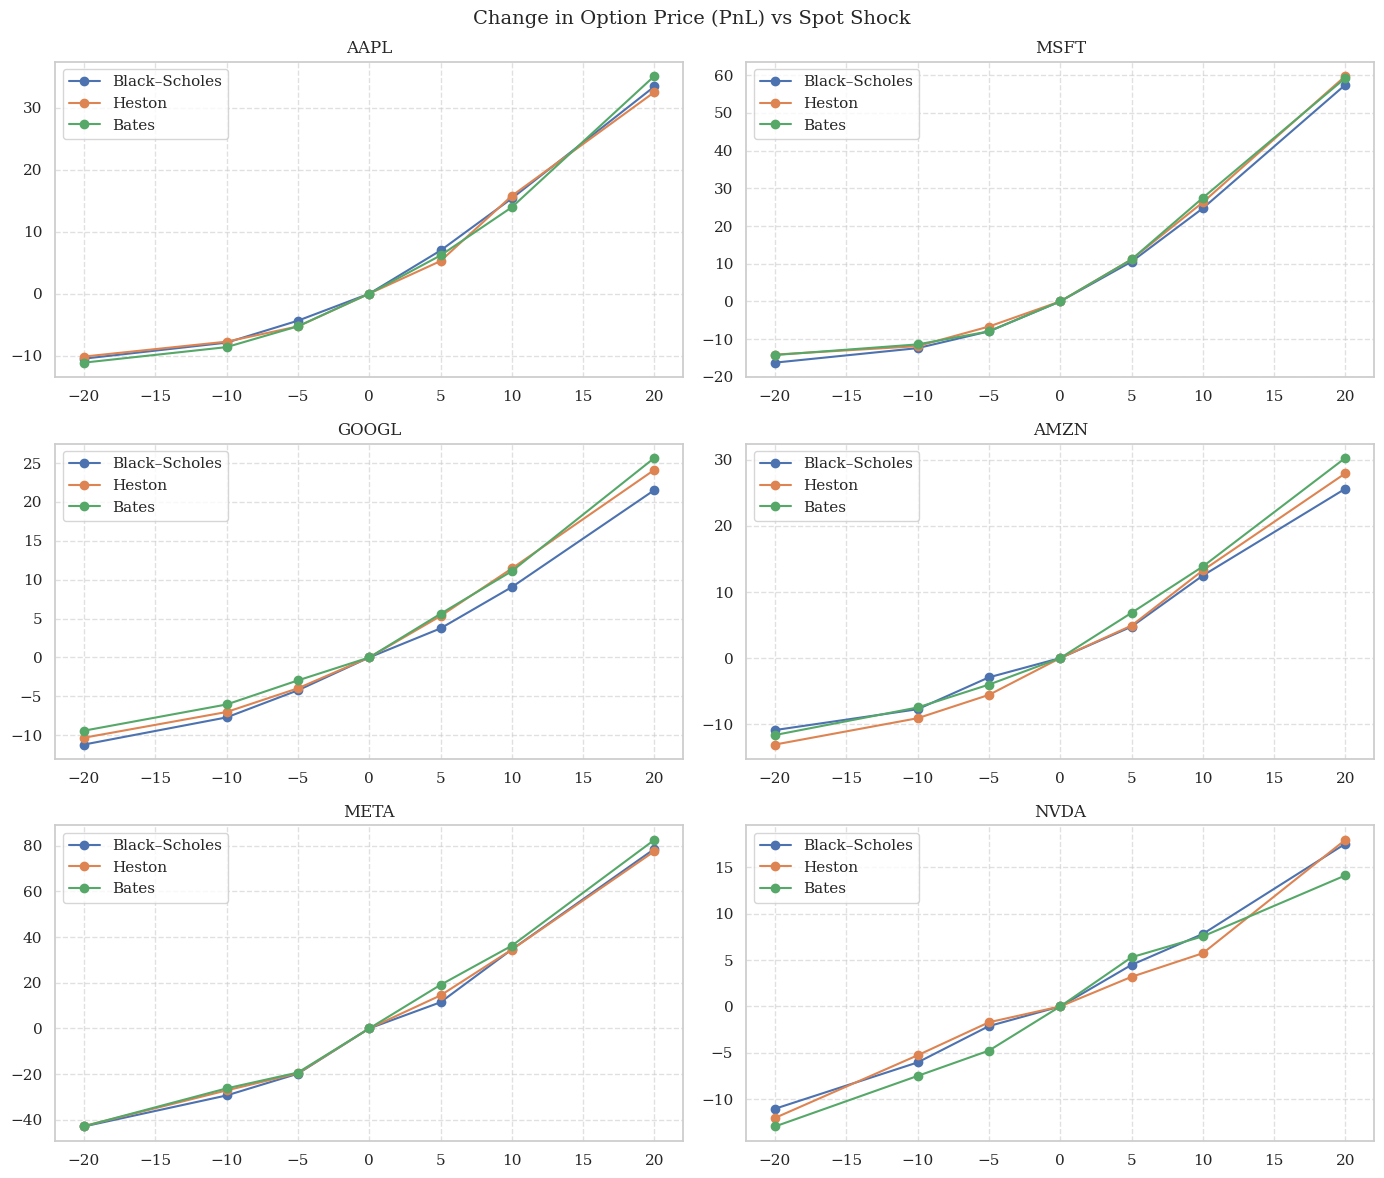

In [11]:
T = 0.5
N = 126
M = 1000
r = 0.02
sigma_dict = stocks_df.pct_change().std() * np.sqrt(252)
spot_shocks = [-0.20, -0.10, -0.05, 0.0, 0.05, 0.10, 0.20]
scenario_results = []

def mc_call_price(paths, K, r, T):
    payoff = np.maximum(paths[:, -1] - K, 0)
    return np.exp(-r * T) * np.mean(payoff)

for stock in stocks:
    S0 = stocks_df[stock].iloc[-1]
    sigma_bs = sigma_dict[stock]
    for shock in spot_shocks:
        shocked_S0 = S0 * (1 + shock)
        bs_paths = simulate_bs(shocked_S0, r, sigma_bs, T, N, M)
        heston_paths, _ = simulate_heston(shocked_S0, sigma_bs**2, r, 2.0, sigma_bs**2, 0.3, -0.5, T, N, M)
        bates_paths, _  = simulate_bates(shocked_S0, sigma_bs**2, r, 2.0, sigma_bs**2, 0.3, -0.5,
                                         0.1, -0.02, 0.05, T, N, M)
        K = S0 * 1.05
        scenario_results.append({
            'Stock': stock,
            'Shock (%)': shock * 100,
            'Black–Scholes': mc_call_price(bs_paths, K, r, T),
            'Heston': mc_call_price(heston_paths, K, r, T),
            'Bates': mc_call_price(bates_paths, K, r, T)
        })

scenario_df = pd.DataFrame(scenario_results)

# Plot PnL-style change
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()
for i, stock in enumerate(stocks):
    df_stock = scenario_df[scenario_df['Stock'] == stock].copy()
    base_prices = df_stock[df_stock['Shock (%)'] == 0].iloc[0]
    for model in ['Black–Scholes', 'Heston', 'Bates']:
        axes[i].plot(df_stock['Shock (%)'], df_stock[model] - base_prices[model], marker='o', label=model)
    axes[i].set_title(stock)
    axes[i].grid(True, linestyle='--', alpha=0.6)
    axes[i].legend()
plt.suptitle('Change in Option Price (PnL) vs Spot Shock', fontsize=14)
plt.tight_layout()
plt.show()